# Evaluation Notebook for Bouncing Balls Experiment

F.X. Vialard and R. Kwitt and S. Wei and M. Niethammer    
**A Shooting Formulation of Deep Learning**    
*NeurIPS 2020*

In [32]:
import os
import numpy as np
import sys
import torch
import torch.nn as nn
from torch.utils import data

%matplotlib inline
import matplotlib.pyplot as plt

sys.path.append('../../')
import neuro_shooting.shooting_blocks as shooting_blocks
import neuro_shooting.shooting_models as shooting_models
import neuro_shooting.generic_integrator as generic_integrator
import neuro_shooting.shooting_hooks as sh
import neuro_shooting.vector_visualization as vector_visualization
import neuro_shooting.validation_measures as validation_measures
import neuro_shooting.parameter_initialization as pi
import neuro_shooting.utils as utils

import PIL
from torchvision.transforms import ToPILImage
from torchvision.transforms import Compose, ToTensor,Resize

from autoencoder import ShootingAE
from utils import load_data, Dataset
import scipy.stats as ss

Results from [ODE$^2$VAE paper](https://arxiv.org/abs/1905.10994) for later use.

In [33]:
paper = {'odevae':[ 
         0.0197,
         0.0163,
         0.0134,
         0.0108,
         0.0087,
         0.0070,
         0.0058,
         0.0046,
         0.0037,
         0.0032],
         'ddpae':[
         0.0400,
         0.0355,
         0.0318,
         0.0285,
         0.0252,
         0.0221,
         0.0192,
         0.0162,
         0.0132,
         0.0105],
         'dtsbn-s':[
         0.1333,
         0.1237,
         0.1126,
         0.0996,
         0.0849,
         0.0683,
         0.0506,
         0.0337,
         0.0182,
         0.0067]}

In [124]:
import pickle
from torchvision.utils import make_grid

def collect_results(path, batch_id, sample_ids=[1], do_plot=False):
    
    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
        plt.axis('off')
    
    with open(os.path.join(path, 'bball_stats.pkl'), 'rb') as fid:
        data = pickle.load(fid)
    
    if do_plot:
        for sid in sample_ids:
            Rs = torch.tensor(data['test_hat'][batch_id][sid]).unsqueeze(1)
            Vs = torch.tensor(data['test_tru'][batch_id][sid]).unsqueeze(1)

            img_list0 = [Rs[i,...] for i in range(10)]
            img_list1 = [Vs[i,...] for i in range(10)]
            plt.figure(figsize=(20,4))
            show(make_grid(img_list0, padding=2, nrow=10, normalize=True, pad_value=1))
            plt.savefig(os.path.join(path, 'pred_{}_{}.pdf'.format(batch_id, sid)),
                        bbox_inches='tight',
                        pad_inches=0)

            plt.figure(figsize=(20,4))
            show(make_grid(img_list1, padding=2, nrow=10, normalize=True, pad_value=1))
            plt.savefig(os.path.join(path, 'true_{}_{}.pdf'.format(batch_id, sid)),
                        bbox_inches='tight',
                        pad_inches=0)

        plt.figure(figsize=(6,3))
        plt.plot(range(1,10+1), np.mean(data['test_errors'], axis=0), color='black', 
                 lw=3, 
                 label='Ours ({:.4f})'.format(data['test_error']))    
        plt.plot(range(1,10+1), paper['odevae'][::-1], 
                 label='ODEVAE ({:.4f})'.format(np.mean(paper['odevae'])))
        plt.plot(range(1,10+1), paper['ddpae'][::-1], 
                 label='DDPAE ({:.4f})'.format(np.mean(paper['ddpae'])))
        plt.plot(range(1,10+1), paper['dtsbn-s'][::-1], 
                 label='DTSBN-S ({:.4f})'.format(np.mean(paper['dtsbn-s'])))

        plt.xlabel('Extrapolated time points (after seeing 3 inputs)')
        plt.ylabel('Predictive MSE')
        plt.xlim((1,10))
        plt.legend()
        plt.grid()
        plt.ylim((0,0.2))

        # Save figure
        #plt.savefig(os.path.join(path, 'performance.pdf'), 
        #            bbox_inches='tight',
        #            pad_inches=0)            
    return np.mean(data['test_errors'],axis=0)

Lets load the results of a trained **dyn. w particles UpDown** model:

In [146]:
path = 'bouncing_balls_runs/balls_sd_40_if_20_pw_1_np_100_norm_weight_0.0005_run_1_ours/'

avg_mse = collect_results(path,1,list(range(18,24)), False)

print('Predicted MSE over time points:')
for t,mse in enumerate(avg_mse): print('Time point {:02d}: {:.4f}'.format(t,mse))
print('Mean predicted MSE (over all time points)', np.mean(avg_mse))

Predicted MSE over time points:
Time point 00: 0.0059
Time point 01: 0.0068
Time point 02: 0.0084
Time point 03: 0.0106
Time point 04: 0.0135
Time point 05: 0.0172
Time point 06: 0.0215
Time point 07: 0.0261
Time point 08: 0.0309
Time point 09: 0.0358
Mean predicted MSE (over all time points) 0.017662222


Plot (1) some exemplary reconstructions from our model (always as two rows: first row is *prediction*, second row is *ground truth*) and the overall results visualization (from the paper):

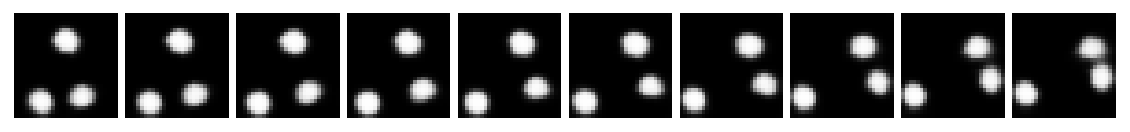

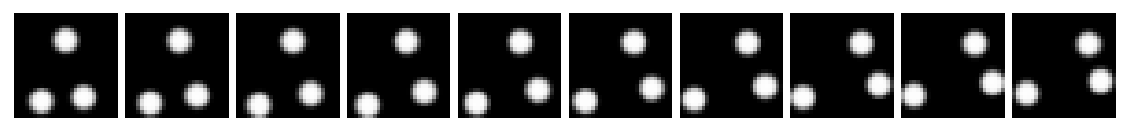

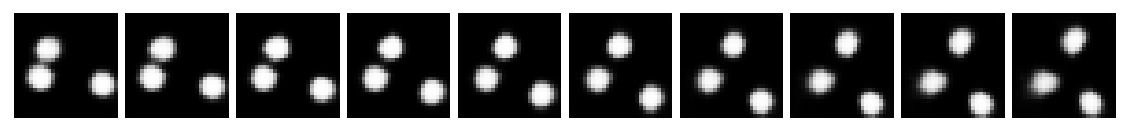

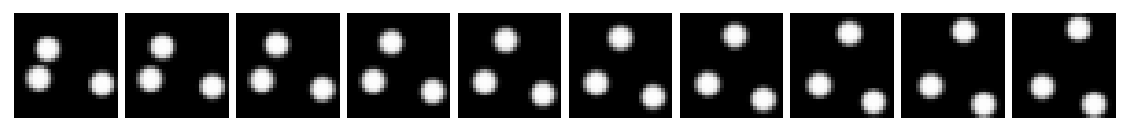

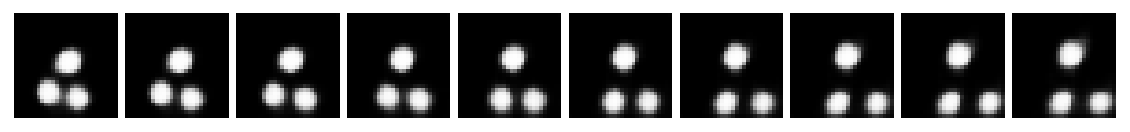

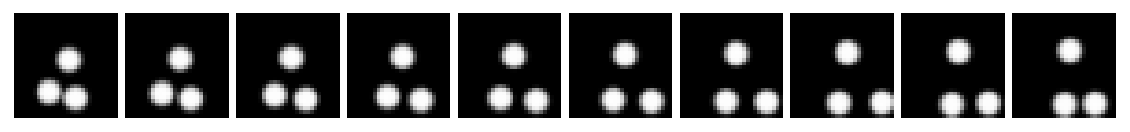

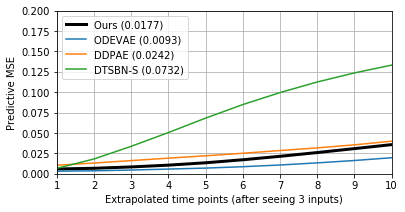

In [147]:
collect_results(path,1,[18,1,7], True);

<div class="alert alert-block alert-info">
<b>Remark</b>: The performance of this model is slightly worse as the one reported in the 
paper, as we only trained with an encoder dimensionality of 40 (the paper reports a dimensionality of 50).
</div>

